<a href="https://colab.research.google.com/github/N0liss/Big-Data/blob/main/Lab02_Spotify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
path = "/content/drive/MyDrive/Colab/Canciones_Spotify.csv"
df = pd.read_csv(path)

# Laboratorio 2 - Clasificador de canciones de Spotify


## KNN (K-Nearest Neighbors)

Elección de las características óptimas para el entrenamiento del modelo

### Realizo una matriz de correlación para saber qué características están más relacionadas con la columna 'target'

<ipython-input-3-4bd3120bd1da>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


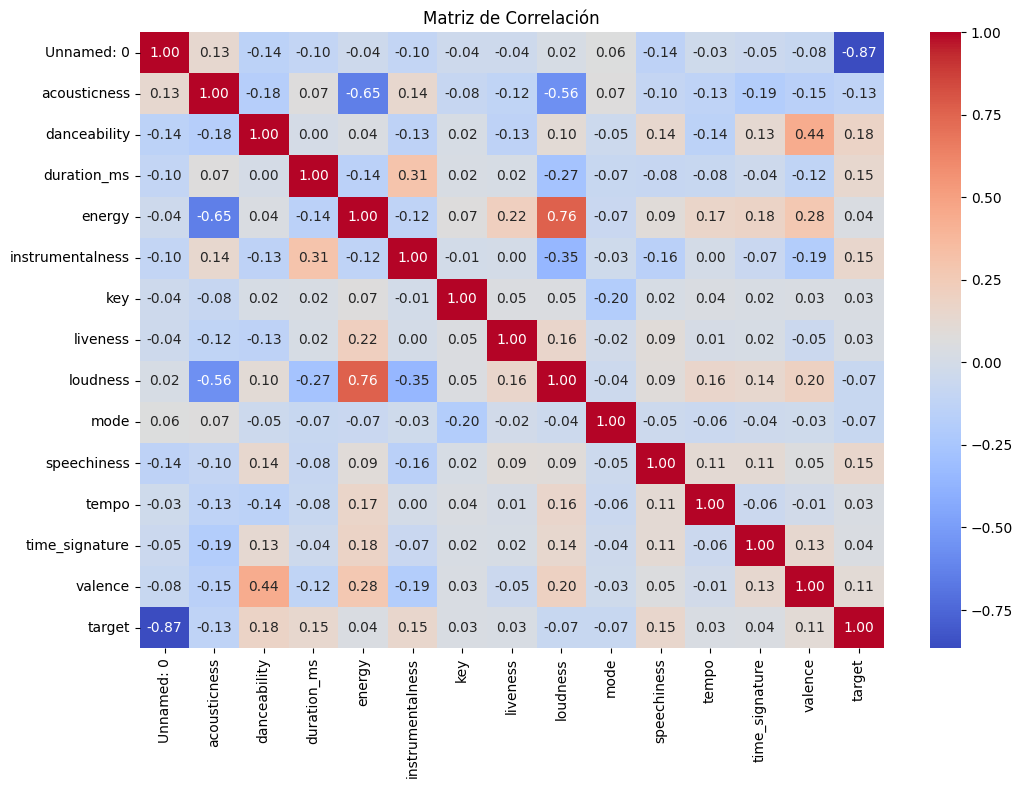

In [ ]:
correlation_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matriz de Correlación")
plt.show()

In [ ]:
# Defino un umbral de correlación
umbral_correlacion = 0.1 # Defino este umbral segun el grafico anterior se ve que las caracteristicas en la relacion del target mas altos son de 0.1 para arriba

# Filtro las características con una correlación significativa
caracteristicas_relevantes = correlation_matrix[abs(correlation_matrix['target']) > umbral_correlacion].index

# DataFrame con las características relevantes
df_relevante = df[caracteristicas_relevantes]
df_relevante.drop(['duration_ms'], axis=1) # Elimino esta columna ya que por mas que tenga un nivel alto de correlacion en la matriz, segun mi experiencia no afecta a la desicion del oyente si la cancion le gusta o no

,Unnamed: 0,acousticness,danceability,instrumentalness,speechiness,valence,target
0,0,0.01020,0.833,0.021900,0.4310,0.286,1
1,1,0.19900,0.743,0.006110,0.0794,0.588,1
2,2,0.03440,0.838,0.000234,0.2890,0.173,1
3,3,0.60400,0.494,0.510000,0.0261,0.230,1
4,4,0.18000,0.678,0.512000,0.0694,0.904,1
...,...,...,...,...,...,...,...
2012,2012,0.00106,0.584,0.002690,0.3330,0.211,0
2013,2013,0.08770,0.894,0.001670,0.1310,0.867,0
2014,2014,0.00857,0.637,0.003990,0.1070,0.470,0
2015,2015,0.00164,0.557,0.677000,0.1330,0.623,0


### Separar en datos de entrenamiento y datos de prueba

In [ ]:
X = df_relevante.drop("target", axis=1)  # Características
y = df_relevante["target"]  #objetivo

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Creación del modelo

In [ ]:
knn = KNeighborsClassifier(n_neighbors=3) #k=3 solo para iniciar con un valor

####Validación cruzada

In [ ]:
cv = 5  # Número de folds para probar

scores = cross_val_score(knn, X, y, cv=cv)  # X es el conjunto de características e y es la variable objetivo

# Muestra las puntuaciones para cada fold
for fold, score in enumerate(scores, start=1):
    print(f"Fold {fold}: {score}")

# Calcula la puntuación media
mean_score = scores.mean()
print("Puntuación media de Validación Cruzada:", mean_score)

Fold 1: 0.8044554455445545
Fold 2: 0.8836633663366337
Fold 3: 0.8560794044665012
Fold 4: 0.8709677419354839
Fold 5: 0.7344913151364765
Puntuación media de Validación Cruzada: 0.82993145468393


####Entrenar modelo

In [ ]:
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

####Evaluación y análisis del rendimiento

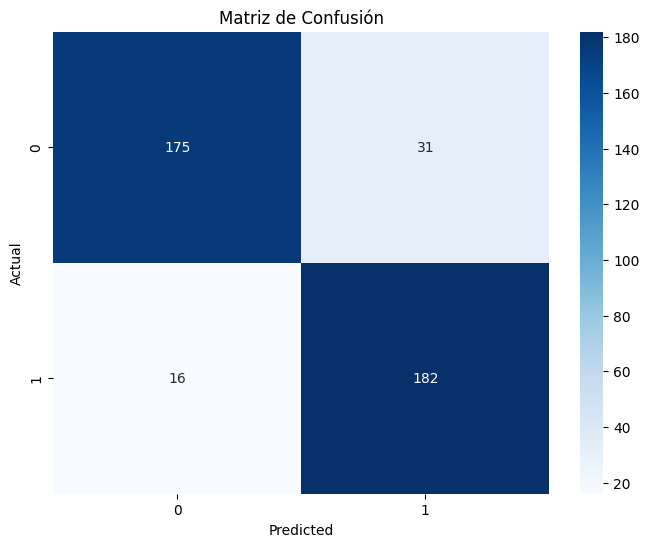

In [ ]:
#La evaluacion siguiente es sin ajuste de hiperparametros
confusion = confusion_matrix(y_test, knn_pred) #Creo la matriz de confusion
# Defino las etiquetas de clases
class_labels = ["0", "1"]

plt.figure(figsize=(8, 6))

# Crea un mapa de calor para la matriz de confusión
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')

plt.show()

#####Calcula la precisión, el recall y el puntaje F1

In [ ]:
precision = precision_score(y_test, knn_pred)
recall = recall_score(y_test, knn_pred)
f1 = f1_score(y_test, knn_pred)

print("Precisión:", precision)
print("Recall:", recall)
print("Puntaje F1:", f1)

Precisión: 0.8544600938967136
Recall: 0.9191919191919192
Puntaje F1: 0.8856447688564477


#### Ajuste de hiperparámetros

#####Grid Search

In [ ]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11],  # Prueba diferentes números de vecinos
    'weights': ['uniform', 'distance'],  # Considera tanto pesos uniformes como ponderación por distancia
    'p': [1, 2],  # Prueba la métrica de distancia de Manhattan (1) y la Euclidiana (2)
}#Elegi estos parametros porque durante la prueba fue los que mejor resultados me dieron, probe con otros como el algoritmo de búsqueda del k pero los resultados no tenian una importanten mejora


grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy')
#Ajusto la cuadrícula al conjunto de datos de entrenamiento:
grid_search.fit(X_train, y_train)
#Encuentro los mejores hiper parámetros:
best_params = grid_search.best_params_
print("Mejores hiperparámetros encontrados:", best_params)

Mejores hiperparámetros encontrados: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}


######Entrena el modelo KNN con los mejores hiperparámetros:

In [ ]:
best_knn = KNeighborsClassifier(**best_params)
#entreno el clasificador con los mejores hiper parametros encontrados
best_knn.fit(X_train, y_train)
y_pred_best = best_knn.predict(X_test)

######Volver a evaluar pero con los hiperparámetros distintos

In [ ]:
# Calcula la matriz de confusión
confusion_best = confusion_matrix(y_test, y_pred_best)

# Calcula precisión, recall y F1-score
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

print("Precisión con los Mejores Hiperparámetros:", precision_best)
print("Recall con los Mejores Hiperparámetros:", recall_best)
print("Puntaje F1 con los Mejores Hiperparámetros:", f1_best)

Precisión con los Mejores Hiperparámetros: 0.8851674641148325
Recall con los Mejores Hiperparámetros: 0.9343434343434344
Puntaje F1 con los Mejores Hiperparámetros: 0.9090909090909092


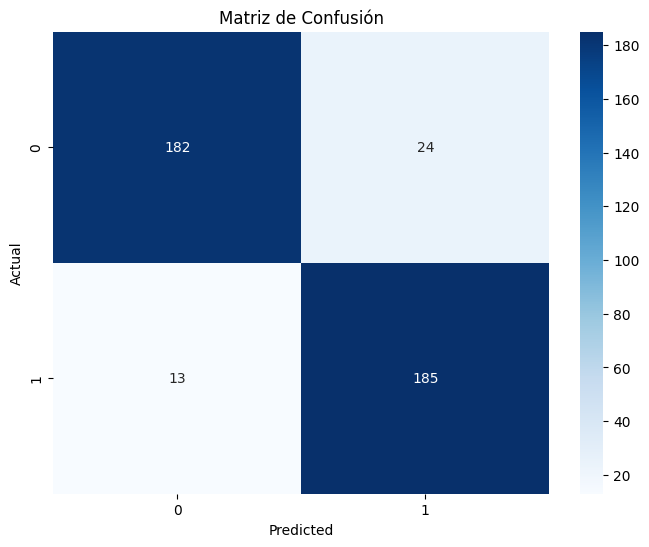

In [ ]:
class_labels = ["0", "1"]

plt.figure(figsize=(8, 6))

# Crea un mapa de calor para la matriz de confusión
sns.heatmap(confusion_best, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')

plt.show()

#####Random Search

In [ ]:
param_dist = {
    'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9,10, 11],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
    'leaf_size': [20, 30, 40]
} #utilice el mismo criterio en estos parámetros que con el Grid Search
random_search = RandomizedSearchCV(KNeighborsClassifier(), param_distributions=param_dist, n_iter=10, cv=5, scoring='accuracy', random_state=42)

random_search.fit(X_train, y_train)
best_random_params = random_search.best_params_
print("Mejores hiperparámetros encontrados con Random Search:", best_random_params)

Mejores hiperparámetros encontrados con Random Search: {'weights': 'distance', 'p': 1, 'n_neighbors': 10, 'leaf_size': 30}


In [ ]:
best_knn_random = KNeighborsClassifier(**best_random_params)
best_knn_random.fit(X_train, y_train)
y_pred_best_random = best_knn_random.predict(X_test)

######Volver a evaluar pero con los hiperparámetros distintos

In [ ]:
# Calcula la matriz de confusión
confusion_best_random = confusion_matrix(y_test, y_pred_best_random)

# Calcula precisión, recall y F1-score
precision_best_random = precision_score(y_test, y_pred_best_random)
recall_best_random = recall_score(y_test, y_pred_best_random)
f1_best_random = f1_score(y_test, y_pred_best_random)

print("Precisión con los Mejores Hiperparámetros:", precision_best_random)
print("Recall con los Mejores Hiperparámetros:", recall_best_random)
print("Puntaje F1 con los Mejores Hiperparámetros:", f1_best_random)

Precisión con los Mejores Hiperparámetros: 0.8720379146919431
Recall con los Mejores Hiperparámetros: 0.9292929292929293
Puntaje F1 con los Mejores Hiperparámetros: 0.8997555012224939


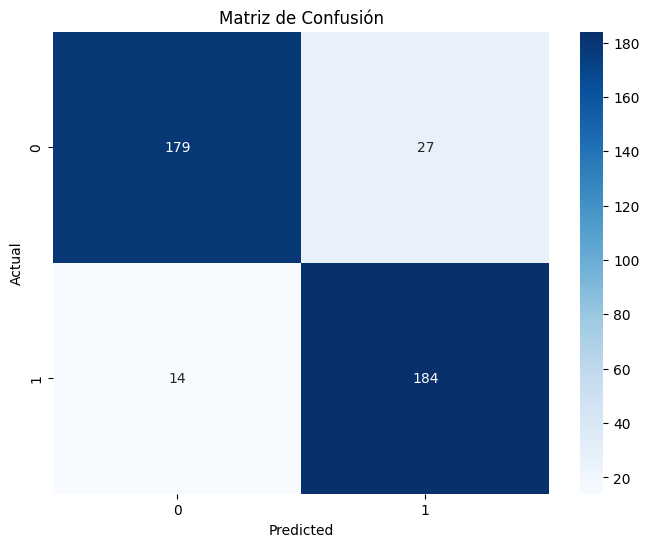

In [ ]:
class_labels = ["0", "1"]

plt.figure(figsize=(8, 6))

sns.heatmap(confusion_best_random, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')

plt.show()

## Árbol de decisión (Decision tree)

### Elección de las características óptimas para el entrenamiento del modelo

In [ ]:
# Selecciono aquellas características que creo yo son de importancia
X = df[['tempo', 'speechiness', 'valence', 'danceability', 'energy']]
y = df['target'] # El target que va a ser 0 o 1

### Separo en datos de entrenamiento y datos de prueba

In [ ]:
# Separo en datos de entrenamiento y datos de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
division_datos = [(X_train, 'X_train'), (X_test, 'X_test'), (y_train, 'y_train'), (y_test, 'y_test')]

for data, name in division_datos:
    print(f'Forma de {name}: {data.shape}')

Forma de X_train: (1613, 5)
Forma de X_test: (404, 5)
Forma de y_train: (1613,)
Forma de y_test: (404,)


El print de las formas de los conjuntos no son de relevancia o no forman parte del proceso de entrenamiento y evaluación del modelo pero aún así me es útil para verificar que la división de los datos se haya realizado correctamente.

### Creación del modelo Árbol de Decisión (Decision Tree)

In [ ]:
# Creo el objeto con el modelo y le asigno un 'random_state' de 42
decision_tree = DecisionTreeClassifier(random_state=42)

In [ ]:
# Entreno el modelo con los datos de entrenamiento
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### Validación cruzada

Realizamos el tipo de validación cruzada (Cross Validation) para evaluar el rendimiento del modelo.

In [ ]:
cv = 5

cv_score_dt = cross_val_score(decision_tree, X, y, cv=cv)

mean_score_dt = cv_score_dt.mean()

print(f'Scores de Cross Validation: {cv_score_dt}')
print(f'Puntuación media de Cross Validation: {mean_score_dt}')

Scores de Cross Validation: [0.53960396 0.55445545 0.49875931 0.58312655 0.56575682]
Puntuación media de Cross Validation: 0.5483404171682678


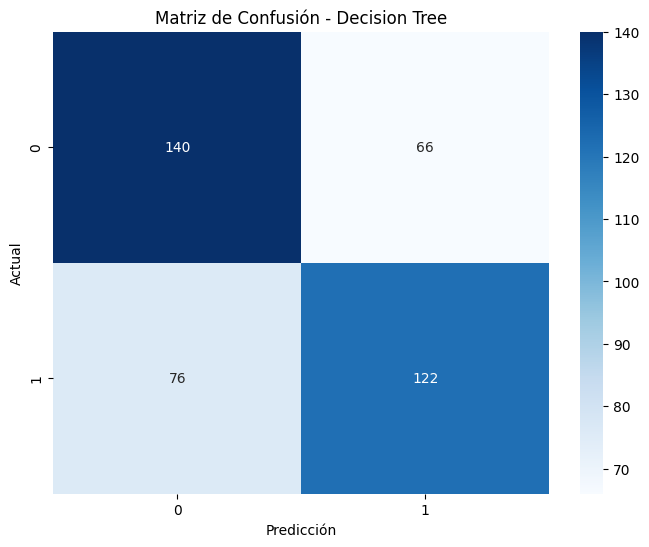

In [ ]:
# Predicciones en el conjunto de prueba
dt_pred = decision_tree.predict(X_test)

# Matriz de Confusión
c_dt = confusion_matrix(y_test, dt_pred)

# Seteo y visualizo la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(c_dt, annot=True, fmt='g', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión - Decision Tree')

plt.show()

### Evaluación y análisis del rendimiento del modelo con Precision, Recall y el F1-score

In [ ]:
# Calculo la precisión, el recall y el score de F1 en el conjunto de prueba

precision = precision_score(y_test, dt_pred)
print(f'Precisión: {precision}')

recall = recall_score(y_test, dt_pred)
print(f'Recall: {recall}')

f1 = f1_score(y_test, dt_pred)
print(f'F1-score: {f1}')

Precisión: 0.648936170212766
Recall: 0.6161616161616161
F1-score: 0.6321243523316062


### Ajusto los hiperparámetros del modelo

#### Grid Search:

In [ ]:
param_grid_dt = {'criterion': ['gini', 'entropy'], 'max_depth': [None, 10, 20, 30], # 'criterion': mide la calidad de una división en el modelo (gini o entropía)
              'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]} # 'max_depth': límite de profundidad del árbol
            # 'min_samples_split': nros. mín. de muestras para dividir un nodo
            # 'min_samples_leaf': el mín. de muestras por hoja


# Creo el objeto de GridSearchCV
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_dt, cv=5, scoring='accuracy')

# Ajusto el GS al conjunto de datos de entrenamiento
grid_search_dt.fit(X_train, y_train)

# Encuentro y muestro los mejores hiperparámetros:
best_params_dt = grid_search_dt.best_params_
print(f'Mejores parámetros: {best_params_dt}')

# Obtengo el modelo con los mejores hiperparámetros
best_decision_tree = grid_search_dt.best_estimator_

Mejores parámetros: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}


### Matriz de Confusión con los Mejores Hiperparámetros:

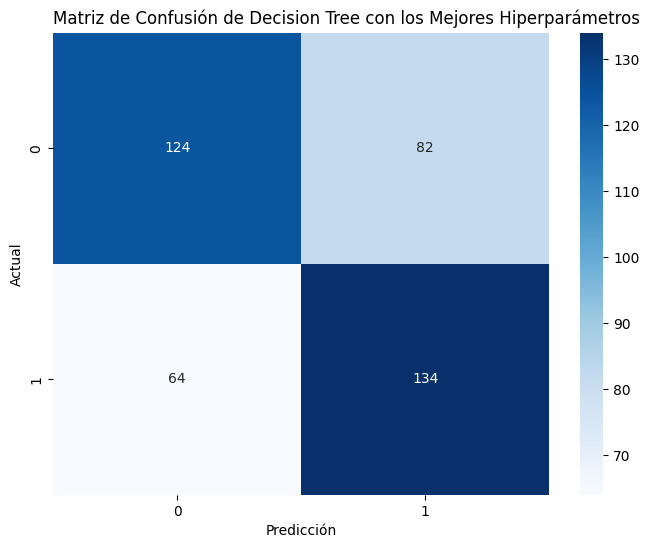

In [ ]:
# Modelo con los mejores hiperparámetros para realizar las predicciones
y_pred_best_dt = best_decision_tree.predict(X_test)

# Creo la Matriz de Confusión ya con el modelo optimizado
c_best = confusion_matrix(y_test, y_pred_best_dt)

# Seteo y visualizo la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(c_best, annot=True, fmt='d', cmap='Blues', xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión de Decision Tree con los Mejores Hiperparámetros', loc='left')

plt.show()

### Evaluación y análisis del rendimiento del modelo con los mejores hiperparámetros

In [ ]:
# Calculo la precisión, recall y el F1-score con los mejores hiperparámetros
precision_best_dt = precision_score(y_test, y_pred_best_dt)
recall_best_dt = recall_score(y_test, y_pred_best_dt)
f1_best_dt = f1_score(y_test, y_pred_best_dt)

print(f'Precisión con los mejores hiperparámetros: {precision_best_dt}')
print(f'Recall con los mejores hiperparámetros: {recall_best_dt}')
print(f'F1-score con los mejores hiperparámetros: {f1_best_dt}')

Precisión con los mejores hiperparámetros: 0.6203703703703703
Recall con los mejores hiperparámetros: 0.6767676767676768
F1-score con los mejores hiperparámetros: 0.6473429951690821


## Bayes (Naive Bayes)

### Elección de las características óptimas para el entrenamiento del modelo

In [ ]:
# Selecciono otra combinación de características para ir probando con este modelo
X = df[['instrumentalness', 'acousticness', 'valence', 'energy', 'danceability']]
y = df['target'] # El target que siempre va a ser 0 o 1

### Separo en datos de entrenamiento y datos de prueba

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [ ]:
division_datos_nb = [(X_train, 'X_train'), (X_test, 'X_test'), (y_train, 'y_train'), (y_test, 'y_test')]

for data, name in division_datos_nb:
    print(f'Forma de {name}: {data.shape}')

Forma de X_train: (1008, 5)
Forma de X_test: (1009, 5)
Forma de y_train: (1008,)
Forma de y_test: (1009,)


### Creación del modelo Bayes (Naive Bayes)

In [ ]:
# Creo el objeto con el modelo
naive_bayes = GaussianNB() # entre el modelo MNB y el GaussianNB elegí éste último ya que es adecuado para datos numéricos continuos

naive_bayes.fit(X_train, y_train) # Entrenamos el modelo

GaussianNB()

### Validación cruzada

In [ ]:
cv = 5

# Realizo validación cruzada
cv_scores_nb = cross_val_score(naive_bayes, X_train, y_train, cv=cv)

mean_score_nb = cv_scores_nb.mean()

# Muestro los resultados de la validación cruzada
print(f'Scores de Cross Validation: {cv_scores_nb}')
print(f'Puntuación media de Cross Validation: {mean_score_nb}')

Scores de Cross Validation: [0.54950495 0.61881188 0.56930693 0.5920398  0.6119403 ]
Puntuación media de Cross Validation: 0.5883207723757451


### Matriz de Confusión para el modelo de Bayes



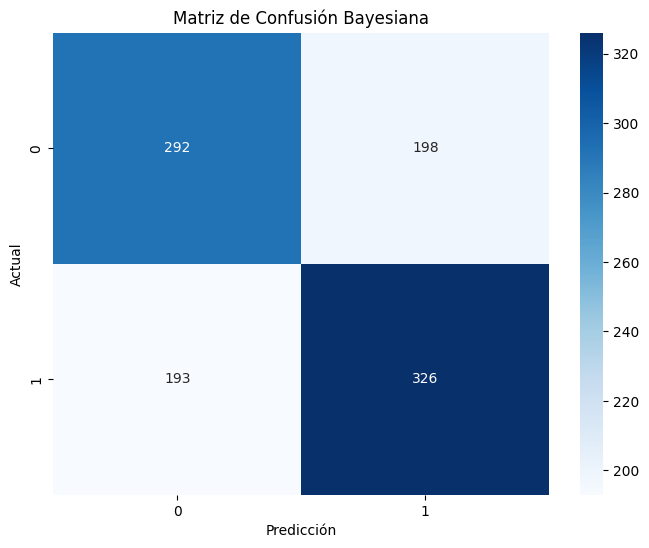

In [ ]:
# Predicciones en el conjunto de prueba
nb_pred = naive_bayes.predict(X_test)

# Matriz de Confusión
confusion_nb = confusion_matrix(y_test, nb_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_nb, annot=True, fmt="d", cmap="Blues", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión Bayesiana')

plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculo la precisión, el recall y el score F1

precision = precision_score(y_test, nb_pred)
print(f'Precisión: {precision}')

recall = recall_score(y_test, nb_pred)
print(f'Recall: {recall}')

f1 = f1_score(y_test, nb_pred)
print(f'F1-score: {f1}')

Precisión: 0.6221374045801527
Recall: 0.628131021194605
F1-score: 0.6251198465963567


Se ha probado utilizar Grid Search mientras se declaraba un hiperparámetro común como lo es el "var smoothing" para este modelo pero sin embargo, al ajustarlo con ciertos valores se ha observado en la matriz de confusión que no tuvo un impacto en el rendimiento del modelo por ende se ha descartado.

## SVM (Support Vector Machine)


### Elección de caracteristicas

In [ ]:
# Ordeno las caracteristicas en relacion con el target para ver cuales pueden ser utiles
corr_matrix = df.corr()

corr_target = corr_matrix['target'].sort_values(ascending=False)

corr_target

<ipython-input-38-650442e7c921>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


target              1.000000
danceability        0.176706
speechiness         0.154006
instrumentalness    0.152594
duration_ms         0.146749
valence             0.107930
time_signature      0.040182
energy              0.039688
tempo               0.034732
key                 0.033594
liveness            0.026364
loudness           -0.072000
mode               -0.072336
acousticness       -0.129627
Unnamed: 0         -0.865969
Name: target, dtype: float64

In [ ]:
# Caracteristicas relevantes
X = df[['danceability', 'speechiness', 'instrumentalness', 'valence', 'time_signature']] # duration_ms aunque sea un valor alto la descarto pq no considero que afecte en el gusto
y = df['target']

### Separo en datos de entrenamiento y prueba y creo el modelo

In [ ]:
# Divido los datos en conjuntos de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creo un objeto SVM
svm = SVC()

### Validación cruzada

In [ ]:
scores = cross_val_score(svm, X, y, cv=5)  # "X" es el conjunto de características e "y" es la variable objetivo y cv es el número de folds para probar

# Muestra las puntuaciones para cada fold
for fold, score in enumerate(scores, start=1):
    print(f"Fold {fold}: {score}")

# Calculo la puntuación media
mean_score = scores.mean()
print("Puntuación media de Validación Cruzada:", mean_score)

Fold 1: 0.5495049504950495
Fold 2: 0.6089108910891089
Fold 3: 0.5062034739454094
Fold 4: 0.6129032258064516
Fold 5: 0.6203473945409429
Puntuación media de Validación Cruzada: 0.5795739871753924


### Entreno el modelo


In [ ]:
svm.fit(X_train, y_train)

# Realizo una predicción en los datos de prueba
svm_pred = svm.predict(X_test)

### Matriz de confusión para SVM


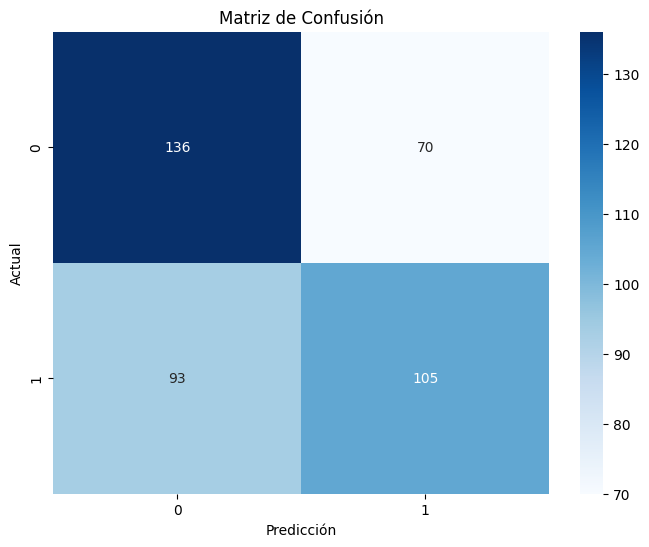

In [ ]:
conf_matrix = confusion_matrix(y_test, svm_pred) # Creo la matriz de confusion
# Defino las etiquetas de clases
class_labels = ["0", "1"]

plt.figure(figsize=(8, 6))

# Crea un mapa de calor para la matriz de confusión
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')

plt.show()

### Calculo la precisión, el recall y el puntaje F1

In [ ]:
precision = precision_score(y_test, svm_pred)
recall = recall_score(y_test, svm_pred)
f1 = f1_score(y_test, svm_pred)

print("Precisión:", precision)
print("Recall:", recall)
print("Puntaje F1:", f1)

Precisión: 0.6
Recall: 0.5303030303030303
Puntaje F1: 0.5630026809651474


### Ajusto los hiperparámetros con Grid Search


In [ ]:
svc = SVC()

param_grid = {
    'kernel': ['linear', 'rbf'],
    'C': [0.1, 1, 10],
    'gamma': [0.1, 1, 10]
}

grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Mejores parámetros: ",grid_search.best_params_)
print("Mejor score:", grid_search.best_score_)


Mejores parámetros:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Mejor score: 0.6757610137876661


### Entreno con los mejores hiperparámetros

In [ ]:
best_svm = SVC(C=10, gamma= 10, kernel= 'rbf')
best_svm.fit(X_train, y_train)
y_pred_best =  best_svm.predict(X_test)

### Calculo la matriz de confusión de los mejores hiperparámetros

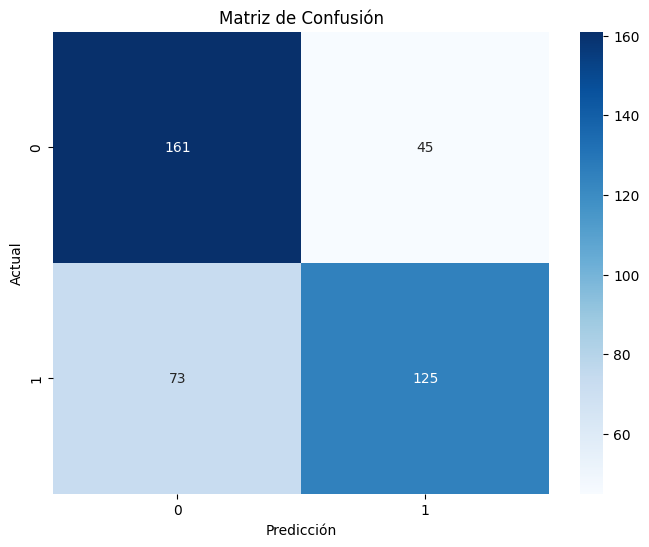

In [ ]:
confusion_best = confusion_matrix(y_test, y_pred_best)

class_labels = ["0", "1"]

plt.figure(figsize=(8, 6))

# Crea un mapa de calor para la matriz de confusión
sns.heatmap(confusion_best, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

plt.xlabel('Predicción')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')

plt.show()

### Precisión, recall y F1-score con los mejores hiperparámetros

In [ ]:
precision_best = precision_score(y_test, y_pred_best)
recall_best = recall_score(y_test, y_pred_best)
f1_best = f1_score(y_test, y_pred_best)

print("Precisión con los Mejores Hiperparámetros:", precision_best)
print("Recall con los Mejores Hiperparámetros:", recall_best)
print("Puntaje F1 con los Mejores Hiperparámetros:", f1_best)

Precisión con los Mejores Hiperparámetros: 0.7352941176470589
Recall con los Mejores Hiperparámetros: 0.6313131313131313
Puntaje F1 con los Mejores Hiperparámetros: 0.6793478260869565


## Ensamble | Votación Mayoritaria

In [ ]:
X = df_relevante
y = df_relevante["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

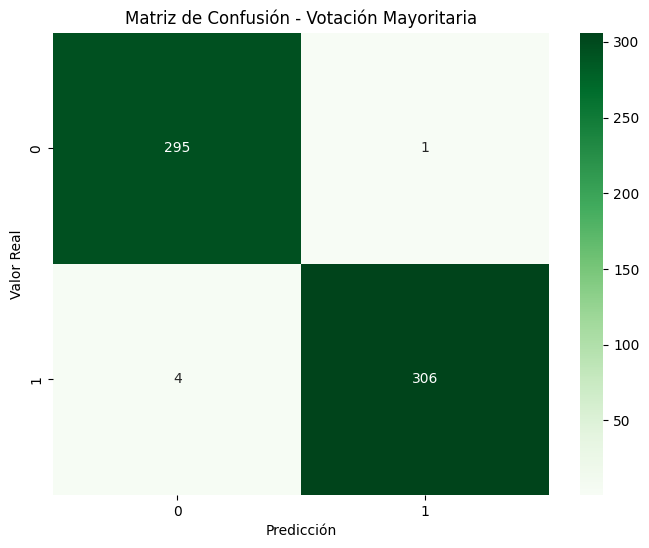

In [ ]:
# 4 modelos entrenados
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

svm = SVC(C=10, gamma=1, kernel='rbf')
svm.fit(X_train, y_train)

naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

knn_pred = knn.predict(X_test)
svm_pred = svm.predict(X_test)
nb_pred = naive_bayes.predict(X_test)
dt_pred = decision_tree.predict(X_test)

final_predictions = []
for k, s, nb, dt in zip(knn_pred, svm_pred, nb_pred, dt_pred):
    votes = {0: 0, 1: 0}
    votes[k] += 1
    votes[s] += 1
    votes[nb] += 1
    votes[dt] += 1

    # Elijo el voto mayoritario
    majority_vote = max(votes, key=votes.get)
    final_predictions.append(majority_vote)

cm_final = confusion_matrix(y_test, final_predictions)

# Matriz de Confusión | VM
plt.figure(figsize=(8, 6))
sns.heatmap(cm_final, annot=True, fmt="d", cmap="Greens", xticklabels=['0', '1'], yticklabels=['0', '1'])
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión - Votación Mayoritaria')

plt.show()